In [1]:
import pandas as pd
import ast

import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

## Elon Musk's Tweets

In [169]:
elon = pd.read_csv('twitter/elonmusk_tweets.csv')

In [170]:
elon.text = elon.text.str.lstrip('b')
elon.created_at = pd.to_datetime(elon.created_at)
elon['date'] = elon.created_at.apply(lambda x: x.date())

In [171]:
# NLP processing from the nltk package
# Instantiate tokenizer to break text into lists of words
#tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9_@-]+')
# Instantiate lemmatizer to turn plural words into singular for better comparison
lemmatizer = WordNetLemmatizer()

In [172]:
# First let's turn each title into a list of words
elon['nlp_text'] = elon.text.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
elon.nlp_text = elon.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
elon.nlp_text = elon.nlp_text.apply(lambda x: ' '.join(x))

In [173]:
elon.nlp_text = elon.nlp_text + ' '
elon = elon.groupby('date')['nlp_text'].sum()
elon = pd.DataFrame(elon)
elon.columns = ['elon_tweet']

## Tesla company tweets

In [174]:
tesla = pd.read_csv('twitter/Tesla_tweets.csv')

In [175]:
tesla.text = tesla.text.str.lstrip('b')
tesla.created_at = pd.to_datetime(tesla.created_at)
tesla['date'] = tesla.created_at.apply(lambda x: x.date())

In [176]:
# First let's turn each title into a list of words
tesla['nlp_text'] = tesla.text.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
tesla.nlp_text = tesla.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
tesla.nlp_text = tesla.nlp_text.apply(lambda x: ' '.join(x))

In [177]:
tesla.nlp_text = tesla.nlp_text + ' '
tesla = tesla.groupby('date')['nlp_text'].sum()
tesla = pd.DataFrame(tesla)
tesla.columns = ['tesla_tweet']

## Techmeme headlines

In [178]:
techmeme = pd.read_csv('web_scraping/techmeme.csv', index_col=0)

In [179]:
techmeme['date_time'] = pd.to_datetime(techmeme.date)
techmeme.date = techmeme.date_time.apply(lambda x: x.date())
techmeme.extra_sources = techmeme.extra_sources.apply(lambda x: ast.literal_eval(x))

In [180]:
techmeme['sources'] = techmeme.extra_sources.copy()
# Ben helped me with this lovely for loop...
for i, list_ in enumerate(techmeme.sources):
    list_.append(techmeme.original_source[i])

In [181]:
techmeme.original_title = techmeme.original_title.apply(lambda x: x.replace('\n', ''))
techmeme.extra_titles = techmeme.extra_titles.apply(lambda x: x.lstrip('[').rstrip(']'))
techmeme['titles'] = techmeme.original_title + ' ' + techmeme.extra_titles

In [182]:
# First let's turn each title into a list of words
techmeme['nlp_text'] = techmeme.titles.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
techmeme.nlp_text = techmeme.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
techmeme.nlp_text = techmeme.nlp_text.apply(lambda x: ' '.join(x))

In [183]:
techmeme.columns = ['date', 'original_source', 'original_title', 'extra_sources',
       'extra_titles', 'date_time', 'news_sources', 'titles', 'news_text']

In [184]:
techmeme.news_text = techmeme.news_text + ' '
techmeme = techmeme.groupby('date')['news_sources', 'news_text'].sum()

# Combine them onto stock data

In merging, I noticed that I was not retaining the same amounts of information.  I realized that since I do not have stock information on weekends, I have nothing to link tweets or news that happens over the weekend.  I should push this to help predict Monday prices, but I am not yet sure how to do that.

In [18]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)
stock['daily_gain'] = stock.close - stock.open
stock['daily_change'] = stock.daily_gain / stock.open
stock['target'] = stock.daily_gain.shift(-1)

In [19]:
stock.tail()

,close,volume,open,high,low,news_sources,news_text,tesla_tweet,elon_tweet,daily_gain,daily_change,target
date,,,,,,,,,,,,
2017-11-16,312.50,5794409.0,313.99,318.14,311.30,NaN,NaN,NaN,NaN,-1.49,-0.004745,-10.62
2017-11-17,315.05,13720830.0,325.67,326.67,313.15,NaN,NaN,going into plaid http t co ouu9s7cuwi bamf htt...,tesla semi http t co 7vlz7f46ji 0 to 100 km h ...,-10.62,-0.032610,-5.05
2017-11-20,308.74,8241821.0,313.79,315.50,304.75,NaN,NaN,NaN,@schesnais good point,-5.05,-0.016094,6.95
2017-11-21,317.81,7256381.0,310.86,318.23,308.71,NaN,NaN,NaN,initial hat offering going great w over 300k i...,6.95,0.022357,-4.17
2017-11-22,312.60,4913283.0,316.77,317.42,311.84,NaN,NaN,NaN,NaN,-4.17,-0.013164,NaN


# Add Change Data as Target

In [20]:
# I will add both and see which makes the most sense
stock['daily_gain'] = stock.close - stock.open
stock['daily_change'] = stock.daily_gain / stock.open

In [21]:
# We'll use gain first because that is the most useful for my purposes (saving more than $5 is necessary as it is cost of trade)
stock['target'] = stock.daily_gain.shift(-1)

# Use CountVectorizer

In [22]:
temp_df = stock[stock.news_text.notnull()]
cvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2), max_features=1000)
cvec.fit(temp_df.news_text.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.news_text.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _news_"
stock = stock.join(cvec_df).drop('news_text',1)

temp_df = stock[stock.tesla_tweet.notnull()]
cvec.fit(temp_df.tesla_tweet.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _tesla_"
stock = stock.join(cvec_df).drop('tesla_tweet',1)

temp_df = stock[stock.elon_tweet.notnull()]
cvec.fit(temp_df.elon_tweet.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _elon_"
stock = stock.join(cvec_df).drop('elon_tweet',1)

del temp_df

In [23]:
stock.news_sources = stock.news_sources.fillna('')
mlb = MultiLabelBinarizer()
stock = stock.join(pd.DataFrame(mlb.fit_transform(stock.news_sources), columns=mlb.classes_, index=stock.index))
stock = stock.drop('news_sources', 1)

In [24]:
stock = stock.fillna(0)

In [25]:
stock.shape

(1866, 3306)

# Train/Test Split

Now this data is technically not time series anymore, so I ought to be able to do a normal train test split.  It seems like news should have some sort of resiliancy over more days, but I did not see any of that in the EDA.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score

In [27]:
# I could drop all the prior day info, because I saw no autocorrelation, but it just seems... odd.
X_train, X_test, y_train, y_test = train_test_split(stock.drop(['target'], 1), stock['target'], test_size=0.3, random_state=42)

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
lr = LinearRegression()

In [30]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [32]:
scores = cross_val_score(lr, X_train, y_train, cv=6)
print("Cross-validated scores:", scores)
print("Average: ", scores.mean())

Cross-validated scores: [ -3.84309171e+10  -4.41054402e+10  -4.29125253e+06  -1.14605854e+08
  -1.54116437e+10  -1.22452532e+10]
Average:  -18385358544.3


Score: -4493513377.69


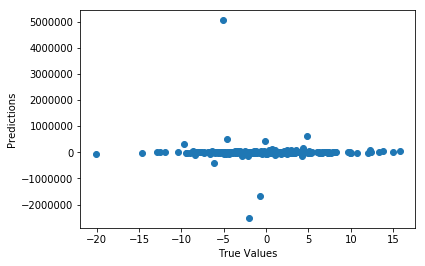

In [33]:
predictions = lr.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", lr.score(X_test, y_test))
plt.show()

In [34]:
from xgboost import XGBRegressor

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
xgb = XGBRegressor(gamma=0, learning_rate=0.02, max_depth=3, n_estimators=100)

In [36]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Score: -0.0126137236781


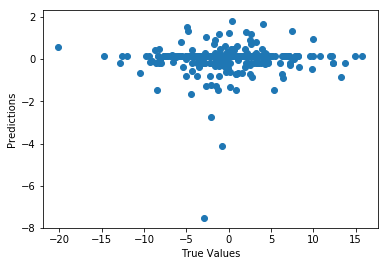

In [37]:
predictions = xgb.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", xgb.score(X_test, y_test))
plt.show()

In [38]:
from sklearn import metrics

In [39]:
accuracy = metrics.r2_score(y_test, predictions)
print("Cross-Predicted Accuracy:", accuracy)

Cross-Predicted Accuracy: -0.0126137236781


In [40]:
X_train, X_test, y_train, y_test = train_test_split(stock.iloc[915:-1].drop(['target'], 1), stock.iloc[915:-1]['target'], test_size=0.3, random_state=42)

Score: 0.0170629618254


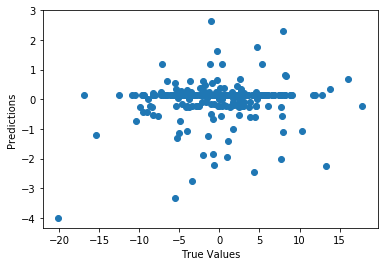

In [41]:
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", xgb.score(X_test, y_test))
plt.show()

Well, it's positive.

# Let's turn this into a classification problem

(And pray)

In [42]:
stock['target_class'] = stock.target.apply(lambda x: 1 if x >= 0 else 0)

In [43]:
stock.target_class.value_counts()

0    957
1    909
Name: target_class, dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(stock.iloc[915:-1].drop(['target', 'target_class'], 1), stock.iloc[915:-1]['target_class'], test_size=0.3, random_state=42)

### Evaluation Function

In [45]:
def eval_sklearn_model(y_true, predictions, model=None, X=None):
    """This function takes the true values for y and the predictions made by the model and prints out the confusion matrix along with Accuracy, Precision, and, if model and X provided, Roc_Auc Scores."""
    cnf_matrix = confusion_matrix(y_true, predictions)

    print('True Negative: ', cnf_matrix[0, 0], '| False Positive: ', cnf_matrix[0, 1])
    print('False Negative: ', cnf_matrix[1, 0], '| True Positive: ', cnf_matrix[1, 1], '\n')

    sensitivity = cnf_matrix[1, 1]/ (cnf_matrix[1, 0] + cnf_matrix[1, 1])
    specificity = cnf_matrix[0, 0]/ (cnf_matrix[0, 1] + cnf_matrix[0, 0])

    print('Sensitivity (TP/ TP + FN): ', sensitivity)
    print('Specificity (TN/ TN + FP): ', specificity, '\n')

    print('Accuracy: ', accuracy_score(y_true, predictions, normalize=True))
    print('Precision: ', precision_score(y_true, predictions))
    if model != None:
        print('Roc-Auc: ', roc_auc_score(y_true, [x[1] for x in model.predict_proba(X)]))
    else:
        pass
    print('\n')

In [46]:
from xgboost import XGBClassifier

In [47]:
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(X_train, y_train)
test_predictions = xgb.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=xgb, X=X_test)

True Negative:  87 | False Positive:  53
False Negative:  92 | True Positive:  53 

Sensitivity (TP/ TP + FN):  0.365517241379
Specificity (TN/ TN + FP):  0.621428571429 

Accuracy:  0.491228070175
Precision:  0.5
Roc-Auc:  0.510123152709




# Sentiment Analysis

In [48]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [49]:
# Reload data as I dropped the nlp columns with count vect
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)
stock['daily_gain'] = stock.close - stock.open
stock['daily_change'] = stock.daily_gain / stock.open
stock['target'] = stock.daily_gain.shift(-1)

In [50]:
stock.news_sources = stock.news_sources.fillna('')
stock.news_text = stock.news_text.fillna('')
stock.tesla_tweet = stock.tesla_tweet.fillna('')
stock.elon_tweet = stock.elon_tweet.fillna('')

In [51]:
sia = SIA()
sentiment = stock['news_text'].apply(sia.polarity_scores)
sent = pd.DataFrame(list(sentiment))
sent.index = stock.index

In [52]:
sent.columns = ['news_compound', 'news_neg', 'news_neu', 'news_pos']
stock = pd.merge(stock, sent, how='left', left_index=True, right_index=True)

In [53]:
sentiment = stock['elon_tweet'].apply(sia.polarity_scores)
sent = pd.DataFrame(list(sentiment))
sent.index = stock.index
sent.columns = ['elon_compound', 'elon_neg', 'elon_neu', 'elon_pos']
stock = pd.merge(stock, sent, how='left', left_index=True, right_index=True)

In [54]:
sentiment = stock['tesla_tweet'].apply(sia.polarity_scores)
sent = pd.DataFrame(list(sentiment))
sent.index = stock.index
sent.columns = ['telsa_compound', 'tesla_neg', 'tesla_neu', 'tesla_pos']
stock = pd.merge(stock, sent, how='left', left_index=True, right_index=True)

### Note on earliest NLP relevant info
1. elon earliest tweet 2013-03-23
2. tesla earliest tweet 2014-02-18
3. techmeme earliest story 2006-12-07

```stock.iloc[915]``` is 2014-02-18

In [55]:
stock.iloc[915:].shape

(951, 24)

In [56]:
stock.columns

Index(['close', 'volume', 'open', 'high', 'low', 'news_sources', 'news_text',
       'tesla_tweet', 'elon_tweet', 'daily_gain', 'daily_change', 'target',
       'news_compound', 'news_neg', 'news_neu', 'news_pos', 'elon_compound',
       'elon_neg', 'elon_neu', 'elon_pos', 'telsa_compound', 'tesla_neg',
       'tesla_neu', 'tesla_pos'],
      dtype='object')

In [57]:
X = stock.iloc[915:-1].drop(['target', 'news_sources', 'news_text', 'tesla_tweet', 'elon_tweet'], 1)
y = stock.iloc[915:-1].target

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
xgb = XGBRegressor(gamma=0, learning_rate=0.02, max_depth=3, n_estimators=100)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [60]:
accuracy = metrics.r2_score(y_train, xgb.predict(X_train))
print("R2 Accuracy:", accuracy)

R2 Accuracy: 0.143272882714


Score: 0.0103119613995


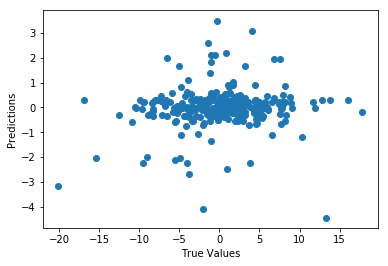

In [61]:
predictions = xgb.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", xgb.score(X_test, y_test))
plt.show()

Well... I mean.  Yup.

# To Classification!

In [62]:
stock['target_class'] = stock.target.apply(lambda x: 1 if x >= 0 else 0)

In [63]:
X = stock.iloc[915:-1].drop(['target', 'target_class', 'news_sources', 'news_text', 'tesla_tweet', 'elon_tweet'], 1)
y = stock.iloc[915:-1].target_class

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(X_train, y_train)
test_predictions = xgb.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=xgb, X=X_test)

True Negative:  75 | False Positive:  65
False Negative:  80 | True Positive:  65 

Sensitivity (TP/ TP + FN):  0.448275862069
Specificity (TN/ TN + FP):  0.535714285714 

Accuracy:  0.491228070175
Precision:  0.5
Roc-Auc:  0.525738916256




Grumble, grumble

# Can I predict the spread of a Day?

Will volatility be changed by the news?

In [66]:
stock.head()

,close,volume,open,high,low,news_sources,news_text,tesla_tweet,elon_tweet,daily_gain,...,news_pos,elon_compound,elon_neg,elon_neu,elon_pos,telsa_compound,tesla_neg,tesla_neu,tesla_pos,target_class
date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,23.89,18751150.0,19.00,25.0000,17.54,,,,,4.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2010-06-30,23.83,17165210.0,25.79,30.4192,23.30,,,,,-1.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2010-07-01,21.96,8216789.0,25.00,25.9200,20.27,,,,,-3.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2010-07-02,19.20,5135795.0,23.00,23.1000,18.71,,,,,-3.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2010-07-06,16.11,6858092.0,20.00,20.0000,15.83,,,,,-3.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [67]:
stock['volatility'] = stock.high - stock.low

In [68]:
X = stock.iloc[915:-1].drop(['target', 'target_class', 'volatility', 'high', 'low', 'close', 'volume', 'open', 'news_sources', 'news_text', 'tesla_tweet', 'elon_tweet', 'daily_gain', 'daily_change'], 1)
y = stock.iloc[915:-1].volatility

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
xgb = XGBRegressor(gamma=0, learning_rate=0.02, max_depth=3, n_estimators=100)
xgb.fit(X_train, y_train)
accuracy = metrics.r2_score(y_train, xgb.predict(X_train))
print("R2 Accuracy:", accuracy)

R2 Accuracy: 0.0287532757729


Score: -0.0883789185676


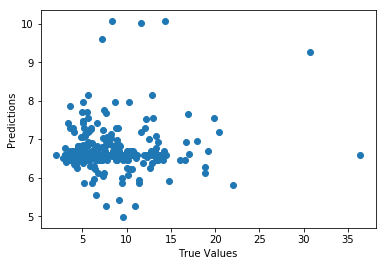

In [71]:
predictions = xgb.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", xgb.score(X_test, y_test))
plt.show()

## With Count Vectorizer?

In [185]:
def sent_analysis(dataframe):
    sia = SIA()
    sentiment = dataframe['news_text'].apply(sia.polarity_scores)
    sent = pd.DataFrame(list(sentiment))
    sent.index = dataframe.index
    
    sent.columns = ['news_compound', 'news_neg', 'news_neu', 'news_pos']
    dataframe = pd.merge(dataframe, sent, how='left', left_index=True, right_index=True)
    
    sentiment = dataframe['elon_tweet'].apply(sia.polarity_scores)
    sent = pd.DataFrame(list(sentiment))
    sent.index = dataframe.index
    sent.columns = ['elon_compound', 'elon_neg', 'elon_neu', 'elon_pos']
    dataframe = pd.merge(dataframe, sent, how='left', left_index=True, right_index=True)

    sentiment = dataframe['tesla_tweet'].apply(sia.polarity_scores)
    sent = pd.DataFrame(list(sentiment))
    sent.index = dataframe.index
    sent.columns = ['telsa_compound', 'tesla_neg', 'tesla_neu', 'tesla_pos']
    dataframe = pd.merge(dataframe, sent, how='left', left_index=True, right_index=True)
    
    return dataframe

In [212]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)

In [213]:
stock.news_text = stock.news_text.fillna('')
stock.tesla_tweet = stock.tesla_tweet.fillna('')
stock.elon_tweet = stock.elon_tweet.fillna('')

In [214]:
stock = sent_analysis(stock)

In [215]:
temp_df = stock[stock.news_text.notnull()]
cvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2), max_features=1000)
cvec.fit(temp_df.news_text.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.news_text.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _news_"
stock = stock.join(cvec_df).drop('news_text',1)

temp_df = stock[stock.tesla_tweet.notnull()]
cvec.fit(temp_df.tesla_tweet.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _tesla_"
stock = stock.join(cvec_df).drop('tesla_tweet',1)

temp_df = stock[stock.elon_tweet.notnull()]
cvec.fit(temp_df.elon_tweet.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _elon_"
stock = stock.join(cvec_df).drop('elon_tweet',1)

del temp_df

In [216]:
stock.news_sources = stock.news_sources.fillna('')
mlb = MultiLabelBinarizer()
stock = stock.join(pd.DataFrame(mlb.fit_transform(stock.news_sources), columns=mlb.classes_, index=stock.index))
stock = stock.drop('news_sources', 1)
stock = stock.fillna(0)

In [217]:
stock['volatility'] = stock.high - stock.low

In [222]:
X = stock.iloc[925:-1].drop(['volatility', 'volume', 'high', 'low', 'close', 'open'], 1)
y = stock.iloc[925:-1].volatility

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [224]:
xgb = XGBRegressor(gamma=0, learning_rate=0.02, max_depth=3, n_estimators=100)
xgb.fit(X_train, y_train)
accuracy = metrics.r2_score(y_train, xgb.predict(X_train))
print("R2 Accuracy:", accuracy)

R2 Accuracy: 0.0503138202204


Score: -0.080712113206


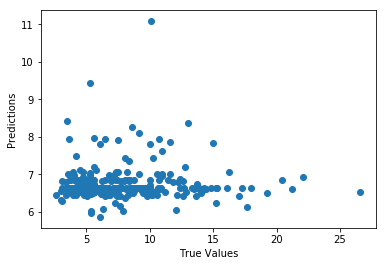

In [225]:
predictions = xgb.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", xgb.score(X_test, y_test))
plt.show()

# Daily Change?

In [199]:
stock['daily_gain'] = stock.close - stock.open
stock['daily_change'] = stock.daily_gain / stock.open

In [200]:
stock['target'] = stock.daily_change.shift(-1)
stock.head()

,close,volume,open,high,low,news_compound,news_neg,news_neu,news_pos,elon_compound,...,iLounge,iMore,iPhone Hacks,iPhone in Canada Blog,lists.swift.org Mailing Lists,volatility,next_day_open,daily_gain,daily_change,target
date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,23.89,18751150.0,19.00,25.0000,17.54,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,7.4600,25.79,4.89,0.257368,-0.075998
2010-06-30,23.83,17165210.0,25.79,30.4192,23.30,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,7.1192,25.00,-1.96,-0.075998,-0.121600
2010-07-01,21.96,8216789.0,25.00,25.9200,20.27,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,5.6500,23.00,-3.04,-0.121600,-0.165217
2010-07-02,19.20,5135795.0,23.00,23.1000,18.71,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,4.3900,20.00,-3.80,-0.165217,-0.194500
2010-07-06,16.11,6858092.0,20.00,20.0000,15.83,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,4.1700,16.40,-3.89,-0.194500,-0.036585


In [201]:
stock['next_day_open'] = stock.open.shift(-1) 
stock['true_grow'] = stock.target.apply(lambda x: 1 if x >= 0 else 0)

In [202]:
X = stock.iloc[925:-1].drop(['volatility', 'volume', 'high', 'low', 'close', 'open', 'target', 'true_grow'], 1)
y = stock.iloc[925:-1].true_grow

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [204]:
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(X_train, y_train)
test_predictions = xgb.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=xgb, X=X_test)

True Negative:  69 | False Positive:  73
False Negative:  68 | True Positive:  72 

Sensitivity (TP/ TP + FN):  0.514285714286
Specificity (TN/ TN + FP):  0.485915492958 

Accuracy:  0.5
Precision:  0.496551724138
Roc-Auc:  0.490945674044


